In [8]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import 
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
tf.set_random_seed(2017)

首先我们从logistic_regression_data.txt中读取数据文件的每一行由三个元素构成, x坐标, y坐标, 对应label对不同label的点赋以不同的值之后可以看看数据的情况

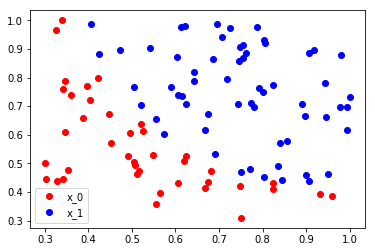

In [10]:
%matplotlib inline

# 从 data.txt 中读入点
with open('dataset/Data.txt', 'r') as f:
    data_list = [i.split('\n')[0].split(',') for i in f.readlines()]
    data = [(float(i[0]), float(i[1]),float(i[2])) for i in data_list]
    
# 标准化
x0_max = max([i[0] for i in data])
x1_max = max([i[1] for i in data])
data = [(i[0]/x0_max, i[1]/x1_max, i[2]) for i in data]

x0 = list(filter(lambda x: x[-1] == 0.0, data)) #选择第一类的点
x1 = list(filter(lambda x: x[-1] == 1.0, data)) #选择第二类的点

plot_x0 = [i[0] for i in x0]
plot_y0 = [i[1] for i in x0]
plot_x1 = [i[0] for i in x1]
plot_y1 = [i[1] for i in x1]

plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

In [11]:
np_data = np.array(data, dtype='float32') # 转换成 numpy array
x_data = tf.constant(np_data[:, 0:2], name='x') # 转换成Tensor 大小是[100, 2]
y_data = tf.expand_dims(tf.constant(np_data[:, -1]), axis=-1)  # 转换成tensor，大小是[100,1]

在之前的练习中, 我们实现了tensorflow下的Sigmoid函数. 实际上我们可以采用"偷懒"的方法--使用tensorflow自带的tf.sigmoid()函数. tensorflow集成了很多这样基本但非常有用的函数, 感兴趣的话可以去 API 手册进行查阅

那么接下来我们就开始构建模型了

In [12]:
# 构建模型
w = tf.get_variable(initializer=tf.random_normal_initializer(seed=2019), shape=(2, 1),name='weights')
b = tf.get_variable(initializer=tf.zeros_initializer(), shape=(1),name='bias')

def logistic_regression(x):
    # 使用 tf.sigmoid 将结果映射到[0, 1]区间
    return tf.sigmoid(tf.matmul(x, w) + b)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

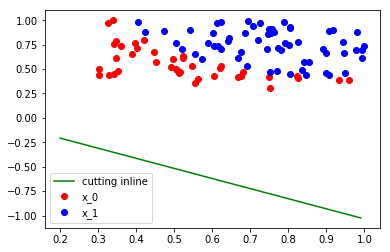

In [15]:
# 画出模型的初始分类效果
%matplotlib inline

# 画出初始分类效果
w_numpy = w.eval(session=sess)
b_numpy = b.eval(session=sess)

w0 = w_numpy[0]
w1 = w_numpy[1]
b0 = b_numpy[0]

plot_x = np.arange(0.2, 1, 0.01)
plot_y = (-w0 * plot_x - b0) /w1

plt.plot(plot_x, plot_y, 'g', label='cutting inline')
plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

可以看到分类效果基本是蒙的, 那么下面我们来尝试优化这个模型优化模型首先定义损失函数这是分类问题中最经典的损失函数计算公式, 我们先来试着定义它

In [16]:
# 定义损失函数
def binary_loss(y_pred, y):
    logit = tf.reduce_mean(y * tf.log(y_pred) + (1 - y) *tf.log(1 - y_pred))
    
    return -logit

In [17]:
y_pred = logistic_regression(x_data)
loss = binary_loss(y_pred, y_data)

print(loss.eval(session=sess))

1.6125079


我们继续用梯度下降法来进行模型优化

In [18]:
# 梯度计算以及参数更新
w_grad, b_grad = tf.gradients(loss, [w, b])

lr = 0.1

w_update = w.assign_sub(lr * w_grad)
b_update = b.assign_sub(lr * b_grad)

# 更新一次参数
sess.run([w_update, b_update])

# 查看更新后的loss
print(loss.eval(session=sess))

1.5589048


上面的参数更新方式其实是繁琐的重复操作, 如果我们参数很多(比如>100), 那么按照上面的方式我们需要写非常多的参数更新op, 这是非常耗时的. 然而, 不用担心, tensorflow已经集成了一套方法来做这个事情, 就是tf.train.Optimizer(优化器).它里面集成了现有的非常多的优化模型的方法, 比如梯度下降, 随机梯度下降, Adam等等, 以后我们会详细的介绍每种方法.并且, 一般来说, 只要你设定了评判模型好坏的损失函数以及每一步参数的更新步⻓, Optimizer就会帮你按照你想要的方式自动的更新所有默认的或者由你指定的参数

In [20]:
# 首先从tf.train中定义一个优化方法
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1, name='optimizer')

# 利用这个优化方法去优化一个损失函数，得到的这个op就是我们想要的
train_op = optimizer.minimize(loss)

现在我们得到了一个train_op, 它实际上等价于上面更新模型的所有操作, 也就是说train_op = 计算梯度 + 参数更新, 我们来看一下它的效果吧

In [22]:
import time

sess.run(tf.global_variables_initializer())

# 这一行用于时间统计，不重要
start = time.time()
for e in range(1000):
    sess.run(train_op)
    
    if (e + 1) % 200 == 0:
        # 计算正确率
        y_true_label = y_data.eval(session=sess)
        y_pred_numpy = y_pred.eval(session=sess)
        y_pred_label = np.greater_equal(y_pred_numpy, 0.5).astype(np.float32)
        accuracy = np.mean(y_pred_label == y_true_label)
        loss_numpy = loss.eval(session=sess)
        print('Epoch %d, Loss: %.4f, Acc: %.4f '% (e + 1, loss_numpy, accuracy))
print()
print('manual_GD cost time : %.4f' % (time.time() - start))

Epoch 200, Loss: 0.3955, Acc: 0.9100 
Epoch 400, Loss: 0.3241, Acc: 0.9200 
Epoch 600, Loss: 0.2904, Acc: 0.9100 
Epoch 800, Loss: 0.2706, Acc: 0.9100 
Epoch 1000, Loss: 0.2575, Acc: 0.9000 

manual_GD cost time : 0.8600


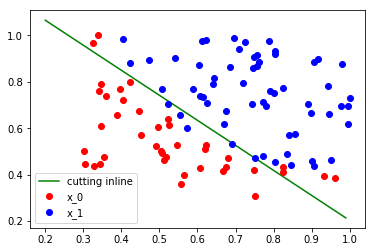

In [23]:
%matplotlib inline

# 画出最终分类效果
w_numpy = w.eval(session=sess)
b_numpy = b.eval(session=sess)

w0 = w_numpy[0]
w1 = w_numpy[1]
b0 = b_numpy[0]

plot_x = np.arange(0.2, 1, 0.01)
plot_y = (-w0 * plot_x - b0) /w1

plt.plot(plot_x, plot_y, 'g', label='cutting inline')
plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

可以看到更新之后模型已经能够基本将这两类点分开了前面我们使用了自己写的 loss，其实tensorflow已经为我们写好了一些常⻅的 loss，比如线性回归里面的 loss是tf.losses.mean_squared_error()，而 Logistic 回归的二分类 loss 在tensorflow中是tf.losses.log_loss，关于更多的 loss，可以查看文档tensorflow为我们实现的 loss 函数有两个好处，第一是方便我们使用，不需要重复造轮子，第二就是其实现是在底层 C++ 语言上的，所以速度上和稳定性上都要比我们自己实现的要好

In [25]:
loss1 = tf.losses.log_loss(predictions=y_pred, labels=y_data)
optimizer1 = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op1 = optimizer1.minimize(loss1)

Instructions for updating:
Use tf.cast instead.


In [26]:
sess.run(tf.global_variables_initializer())
start = time.time()
for e in range(1000):
    sess.run(train_op1)
    
    if (e + 1) % 200 == 0:
        # 计算正确率
        y_true_label = y_data.eval(session=sess)
        y_pred_numpy = y_pred.eval(session=sess)
        y_pred_label = np.greater_equal(y_pred_numpy, 0.5).astype(np.float32)
        accuracy = np.mean(y_pred_label == y_true_label)
        loss_numpy = loss.eval(session=sess)
        print('Epoch %d, Loss: %.4f, Acc: %.4f '% (e + 1, loss_numpy, accuracy))
print()
print('manual_GD cost time : %.4f' % (time.time() - start))

Epoch 200, Loss: 0.5873, Acc: 0.6000 
Epoch 400, Loss: 0.5502, Acc: 0.6600 
Epoch 600, Loss: 0.5190, Acc: 0.7400 
Epoch 800, Loss: 0.4926, Acc: 0.7800 
Epoch 1000, Loss: 0.4700, Acc: 0.8200 

manual_GD cost time : 0.5770


可以看到，使用了tensorflow自带的 loss 之后，速度有了一定的上升，虽然看上去速度的提升并不多，但是这只是一个小网络，对于大网络，使用自带的 loss 不管对于稳定性还是速度而言，都有质的⻜跃，同时也避免了重复造轮子的困扰